In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'sccoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

https://erddap.sccoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/%s.xlsx' % ra.upper())
df

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,NaN,TNWC1,Stearns Wharf,Automated Shore Station,34.4107,-119.6874,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
1,NaN,NaN,Santa Monica Pier,Automated Shore Station,34.0086,-118.4986,fixed,2005,Y,SCCOOS/City of LA/Santa Monica Bay Foundation,Yp,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
2,NaN,NEWC1,Newport Pier,Automated Shore Station,33.6073,-117.9289,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
3,NaN,LJSC1,Scripps Pier,Automated Shore Station,32.8670,-117.2570,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
4,NaN,NaN,Cal Poly Pier,Harmful Algae Bloom monitoring program station,35.1700,-120.7410,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,Cal Poly,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...
5,NaN,NaN,Stearns Wharf,Harmful Algae Bloom monitoring program station,34.4107,-119.6874,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSB,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...
6,NaN,NaN,Santa Monica Pier,Harmful Algae Bloom monitoring program station,34.0086,-118.4986,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,UCLA,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...
7,NaN,NaN,Newport Pier,Harmful Algae Bloom monitoring program station,33.6073,-117.9289,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,USC,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...
8,NaN,NaN,Scripps Pier,Harmful Algae Bloom monitoring program station,32.8670,-117.2570,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...
9,NaN,NaN,Scripps Pier,OAH Monitoring,32.8670,-117.2570,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"pH, dissolved_oxygen, temperature, conductivit...",Todd Martz Self-Calibrating SeapHOx


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
df_wf = df[df['Station Long Name'] == 'Scripps Pier']

# for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
search_for = df_wf['Station Long Name'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

resp = pd.read_csv(search_url)

resp['Dataset ID']

0    HABs-ScrippsPier
1       spc_hab_daily
2              autoss
Name: Dataset ID, dtype: object

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`

In [5]:
## TODO add a dictionary for `Station ID` to `Dataset ID` mapping. This will allow us to check if the `Station ID`
# has multiple `Dataset ID` but is collecting obs for the CY.

not_found = []
found = dict()

for station in df['Station Long Name'].astype(str):
    
    try:
        search_url = e.get_search_url(search_for=station, response="csv")
        resp = pd.read_csv(search_url)
        print("Found \"%s\": %s" % (station,resp['Dataset ID'].values.tolist()))
        
        found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        not_found.append(station)
        pass
#         print('no dataset matching \"%s\"' % station)
#         station_long_name = df.loc[df['Station ID'] == station,'Station Long Name'].values.tolist()[0]
        
#         try:
#             print('searching \"station long name\" = \"%s\"' % station_long_name)
#             search_url = e.get_search_url(search_for=station_long_name, response="csv")
#             resp = pd.read_csv(search_url)
#             print("Found \"%s\": %s" % (station_long_name,resp['Dataset ID'].values.tolist()))
            
#             found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
#         except:
#             print("No dice...")
#             not_found.append(station)
        
    print("\n")

Found "Stearns Wharf": ['HABs-StearnsWharf', 'autoss']


Found "Santa Monica Pier": ['HABs-SantaMonicaPier']


Found "Newport Pier": ['HABs-NewportBeachPier', 'autoss']


Found "Scripps Pier": ['HABs-ScrippsPier', 'spc_hab_daily', 'autoss']


Found "Cal Poly Pier": ['HABs-CalPolyPier', 'HABs-SantaMonicaPier', 'HABs-ScrippsPier', 'HABs-TrinidadPier', 'HABs-NewportBeachPier', 'spc_hab_daily', 'HABs-Humboldt', 'HABs-SantaCruzWharf', 'HABs-HumboldtSouthBay', 'HABs-MontereyWharf', 'HABs-T00', 'HABs-T16', 'HABs-BodegaMarineLab', 'HABs-TomalesBayBuoy', 'HABs-BodegaMarineLabBuoy', 'HABs-StearnsWharf']


Found "Stearns Wharf": ['HABs-StearnsWharf', 'autoss']


Found "Santa Monica Pier": ['HABs-SantaMonicaPier']


Found "Newport Pier": ['HABs-NewportBeachPier', 'autoss']


Found "Scripps Pier": ['HABs-ScrippsPier', 'spc_hab_daily', 'autoss']


Found "Scripps Pier": ['HABs-ScrippsPier', 'spc_hab_daily', 'autoss']


Found "Del Mar Mooring": ['delmar_salinity', 'delmar_temperature']




Print the stations that we couldn't find.

In [6]:
df[df['Station Long Name'].isin(not_found)]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


In [7]:
found

{'Stearns Wharf': {'Dataset ID': ['HABs-StearnsWharf', 'autoss']},
 'Santa Monica Pier': {'Dataset ID': ['HABs-SantaMonicaPier']},
 'Newport Pier': {'Dataset ID': ['HABs-NewportBeachPier', 'autoss']},
 'Scripps Pier': {'Dataset ID': ['HABs-ScrippsPier',
   'spc_hab_daily',
   'autoss']},
 'Cal Poly Pier': {'Dataset ID': ['HABs-CalPolyPier',
   'HABs-SantaMonicaPier',
   'HABs-ScrippsPier',
   'HABs-TrinidadPier',
   'HABs-NewportBeachPier',
   'spc_hab_daily',
   'HABs-Humboldt',
   'HABs-SantaCruzWharf',
   'HABs-HumboldtSouthBay',
   'HABs-MontereyWharf',
   'HABs-T00',
   'HABs-T16',
   'HABs-BodegaMarineLab',
   'HABs-TomalesBayBuoy',
   'HABs-BodegaMarineLabBuoy',
   'HABs-StearnsWharf']},
 'Del Mar Mooring': {'Dataset ID': ['delmar_salinity', 'delmar_temperature']}}

Check if the dataset has coverage for CY 2021

In [8]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Datasets without coverage for 2021:
set()


Show me the inventory metadata about the invalid stations:

In [9]:
bad_stations = df.loc[(df['Station ID'].isin(non_2021_datasets)) | df['Station Long Name'].isin(not_found)]

bad_stations

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


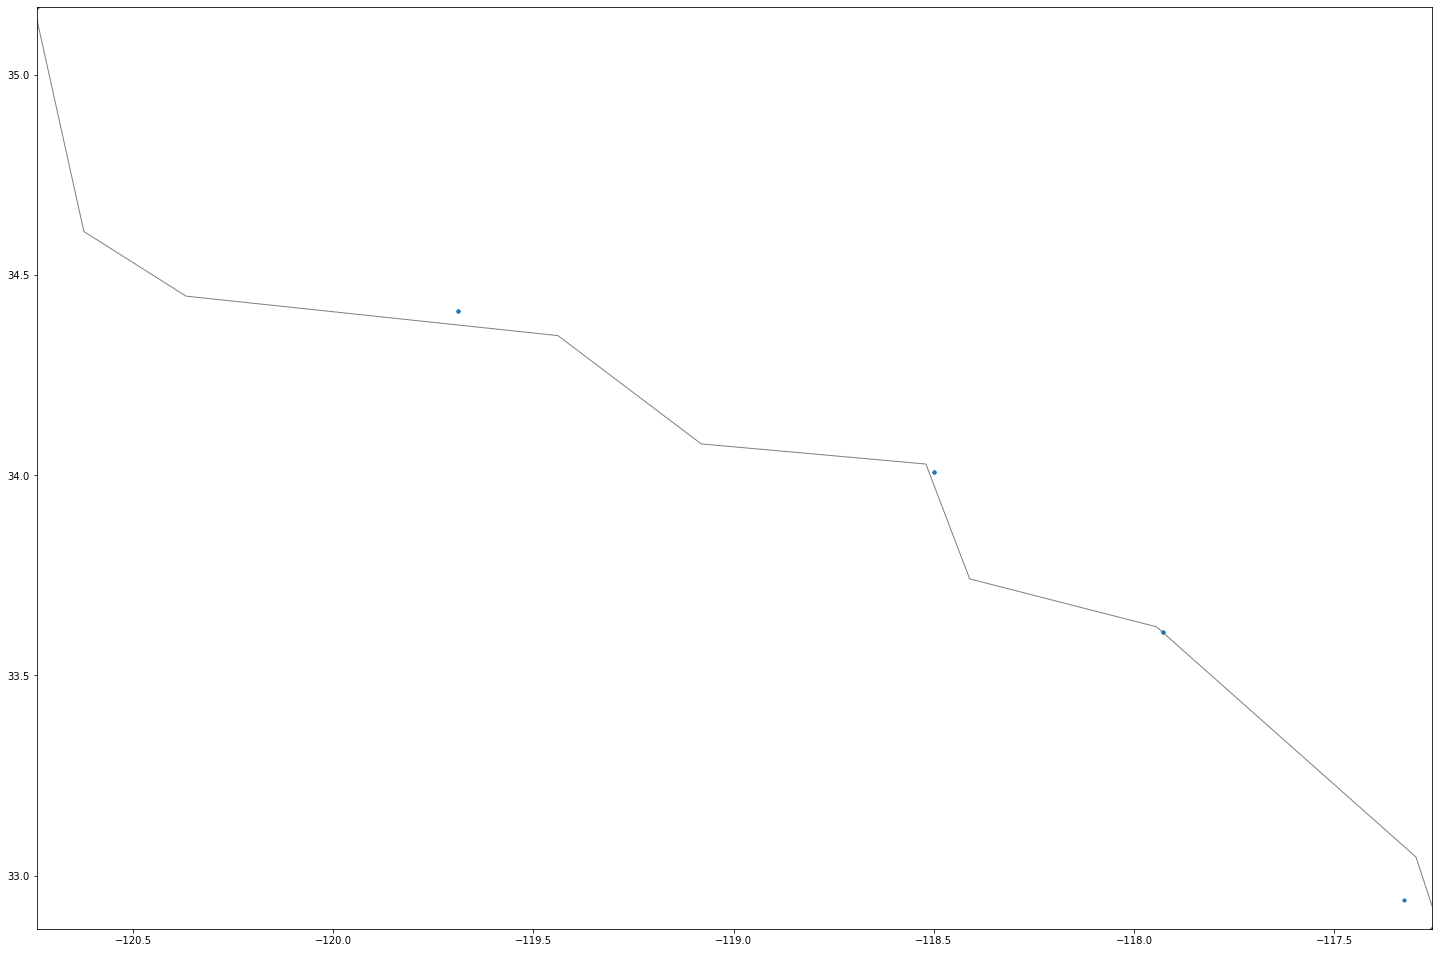

In [20]:
import geopandas
import matplotlib.pyplot as plt

# df['Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)'] = \
#     df['Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)'].astype(str)

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='RA', 
         categorical=True, 
         markersize=10, 
         legend=True,
         k=11,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [21]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore()